In [0]:
# we install the CPU-only version of torch here, since the download is fast
!pip install https://download.pytorch.org/whl/cpu/torch-1.0.0-cp36-cp36m-linux_x86_64.whl
!pip install pyro-ppl 

    100% |████████████████████████████████| 69.4MB 489kB/s 
    100% |████████████████████████████████| 204kB 24.2MB/s 
    100% |████████████████████████████████| 61kB 24.1MB/s 
  Running setup.py bdist_wheel for pyro-ppl ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ed/b5/01/c883fa6e02eb51fd67ba2b73f1ddcee42997716394792d57da
  Running setup.py bdist_wheel for opt-einsum ... - done
  Stored in directory: /root/.cache/pip/wheels/51/3e/a3/b351fae0cbf15373c2136a54a70f43fea5fe91d8168a5faaa4
Successfully built pyro-ppl opt-einsum


In [0]:
import pyro 
import torch 
import pyro.distributions as dist 

import numpy as np 

import seaborn as sns 

from pyro import infer, optim

from pyro.infer.mcmc import HMC, MCMC
from pyro.infer import EmpiricalMarginal

assert pyro.__version__.startswith('0.3')

Let's first generate random samples:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


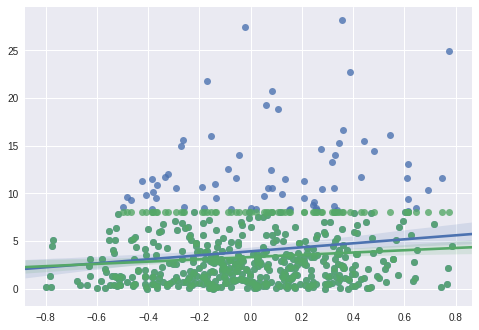

In [0]:
n = 500
a = 2
b = 4
c = 8

x = dist.Normal(0, 0.34).sample((n,))

link = torch.nn.functional.softplus(torch.tensor(a*x + b))
y = dist.Exponential(rate=1 / link).sample()  # note param is rate, not mean

truncation_label = (y > c).float()

y_obs = y.clamp(max=c)

sns.regplot(x.numpy(), y.numpy())
sns.regplot(x.numpy(), y_obs.numpy())

# Modeling using HMC 

Here we will start with a basic model that uses HMC to conduct inference. Here the model is specified in such a way that each individual sample will be looped through sequentially. As a result this can be very slow. So we just let it run a few iterations for demonstration purpose. 

In the next section, we'll introduct much faster way of specifying the model. 

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


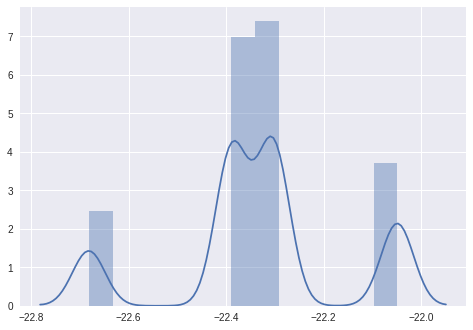

In [0]:
def model(x, y, truncation_label):
  a_model = pyro.sample("a_model", dist.Normal(0, 10))
  b_model = pyro.sample("b_model", dist.Normal(0, 10))
  
  link = torch.nn.functional.softplus(a_model * x + b_model)
  
  for i in range(len(x)):
    y_hidden_dist = dist.Exponential(1 / link[i])
    
    if truncation_label[i] == 0: 
      y_real = pyro.sample("obs_{}".format(i), 
                           y_hidden_dist,
                           obs = y[i])
    else:
      truncation_prob = 1 - y_hidden_dist.cdf(y[i])
      pyro.sample("truncation_label_{}".format(i), 
                  dist.Bernoulli(truncation_prob), 
                  obs = truncation_label[i])
      

pyro.clear_param_store()
hmc_kernel = HMC(model,
                 step_size = 0.1, 
                 num_steps = 4)

mcmc_run = MCMC(hmc_kernel, 
                num_samples=5,
                warmup_steps=1).run(x, y, truncation_label)

marginal_a = EmpiricalMarginal(mcmc_run, 
                               sites="a_model")

posterior_a = [marginal_a.sample() for i in range(50)] 

sns.distplot(posterior_a)

# Modeling using HMC with Vectorized Data

Here we try to make the estimation faster using the `plate` and `mask` function. 

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


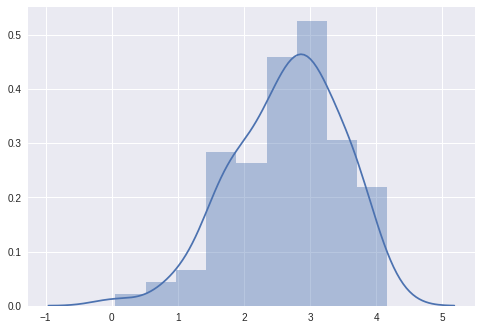

In [0]:
def model(x, y, truncation_label):
  a_model = pyro.sample("a_model", dist.Normal(0, 10)) 
  b_model = pyro.sample("b_model", dist.Normal(0, 10))
  
  link = torch.nn.functional.softplus(a_model * x + b_model) 
  
  with pyro.plate("data"):
    y_hidden_dist = dist.Exponential(1 / link) 
    
    with pyro.poutine.mask(mask = (truncation_label == 0)): 
      pyro.sample("obs", y_hidden_dist,
                  obs = y)
      
    with pyro.poutine.mask(mask = (truncation_label == 1)):
      truncation_prob = 1 - y_hidden_dist.cdf(y)
      pyro.sample("truncation_label", 
                  dist.Bernoulli(truncation_prob), 
                  obs = torch.tensor(1.))
      
      
      
pyro.clear_param_store()
hmc_kernel = HMC(model,
                 step_size = 0.1, 
                 num_steps = 4)

mcmc_run = MCMC(hmc_kernel, 
                num_samples=500,
                warmup_steps=1000).run(x, y, truncation_label)

marginal_a = EmpiricalMarginal(mcmc_run, 
                               sites="a_model")

posterior_a = [marginal_a.sample() for i in range(100)] 

sns.distplot(posterior_a)

# Modeling with SVI

Here we make inference using Stochastic Variational Inference. However here we have to define a guide function. 

In [0]:
from pyro.contrib.autoguide import AutoMultivariateNormal

guide = AutoMultivariateNormal(model)

pyro.clear_param_store()
  
adam_params = {"lr": 0.01, "betas": (0.90, 0.999)}
optimizer = optim.Adam(adam_params)

svi = infer.SVI(model, 
                guide, 
                optimizer, 
                loss=infer.Trace_ELBO())

losses = []
for i in range(5000):
  loss = svi.step(x, y_obs, truncation_label)
  losses.append(loss)

  if i % 1000 == 0:
    print(', '.join(['{} = {}'.format(*kv) for kv in guide.median().items()]))

print('final result:')
for kv in sorted(guide.median().items()):
  print('median {} = {}'.format(*kv))

a_model = 0.009999999776482582, b_model = 0.009999999776482582
a_model = 0.8184720873832703, b_model = 2.8127853870391846
a_model = 1.3366154432296753, b_model = 3.5597035884857178
a_model = 1.7028049230575562, b_model = 3.860581874847412
a_model = 1.9031578302383423, b_model = 3.9552347660064697
final result:
median a_model = 1.9155923128128052
median b_model = 3.9299516677856445


Let's check that the model has converged by plotting losses

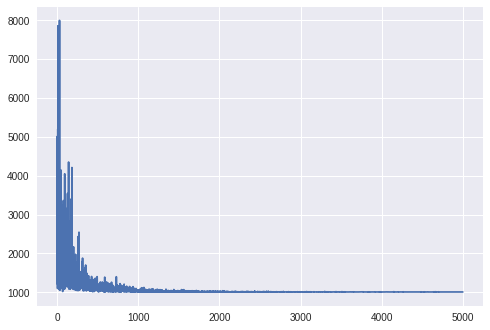

In [0]:
sns.plt.plot(losses);

We can plot approximate posterior distribution using the [guide.quantiles()](http://docs.pyro.ai/en/dev/contrib.autoguide.html#pyro.contrib.autoguide.AutoContinuous.quantiles) function:

/usr/local/lib/python3.6/dist-packages/pyro/contrib/autoguide/__init__.py:429: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  quantiles = loc.new_tensor(quantiles).unsqueeze(-1)


Text(0, 0.5, 'density')

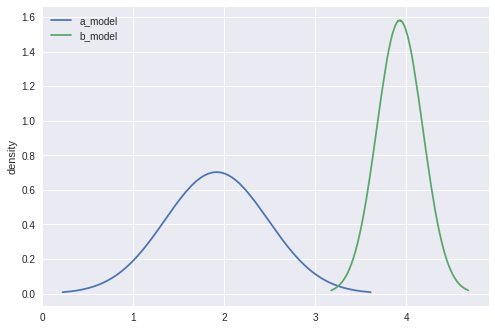

In [0]:
N = 1000
for name, quantiles in guide.quantiles(torch.arange(0., N) / N).items():
  quantiles = np.array(quantiles)
  pdf = 1 / (quantiles[1:] - quantiles[:-1]) / N
  x = (quantiles[1:] + quantiles[:-1]) / 2
  sns.plt.plot(x, pdf, label=name)
  
sns.plt.legend()
sns.plt.ylabel('density')